# Lab 3
The goals of this lab are as follows:
<ol>
    <li> reinforce basic modeling concepts with MCNP/OpenMC</li>
    <li> introduce energy bins for tallies </li>
    <li> introduce non-monoenergetic soruces </li>
    <li> To compare results between 1-group and 2-group Neutron Diffusion Theory and MCNP/OpenMC </li>
    
</ol>

The domain comprises an infinite body of water at room temperature.  A neutron point source is located at the orgin.  The point source is modeled as a low energy (0.0253 eV), high energy (1 MeV) and a Watt Fission spectrum representative of neutrons born from fission of U-235. Flux is measured on a series of concentric spheres around the orign and compared to the flux from 1- and 2-group diffusion theory.
        

## Diffusion Theory Results

As with Lab 2, it's a good approach to have a strong notion of what theory says your computational results should be **before** you undertake the computation.  

The (1-group) diffusion theory solution for flux from a point source in an infinite non-multiplying medium is:
$$\phi(r) = \frac{Se^{-r/L}}{4 \pi D r}$$
where $S$ is the source strength, $D$ is the diffusion coefficient for the medium (which is assumed to be homogeneous), and $L$ is the diffusion length for the (homogeneous) medium.

For 2-group diffusion theory, the neutrons are segregated by energy into a high energy group (group 1) and a low energy group (group 2).  In some contexts the low energy group is considered "Thermal" neutrons and so a subscript "T" is used to denote that flux.  The solution in this case is:
$$\phi_1 = \frac{Se^{-r/\sqrt{\tau_T}}}{4 \pi D_1 r}$$
$$\phi_T = \frac{SL_T^2}{4 \pi r \bar{D}\left(L_T^2-\tau_T \right)}\left(e^{-r/L_T} - e^{-r/\sqrt{\tau_T}}\right)$$

The constants in the above equations have analgous meanings as with 1-group diffusion theory albeit for thier individual groups.  The constants $\bar{D}$ and $L_T$ are the diffusion coefficent and diffusion length for "thermal" neutrons; this number varies with temperature as does the thermal neutron energy spectrum and can be obtained from standard data references.

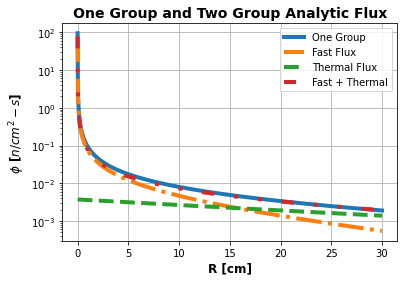

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

S = 1; #n/s, representative unit source strength
D = 0.84; #cm, diffusion coefficient for water
L = 59; # cm, diffusion length for water at 20 degrees C
 
# one group flux
def phi(r):
    return (S/(4.*np.pi*D*r))*np.exp(-r/L);

# two-group result
D1 = 1.016; # cm, diffusion coefficient for fast neutrons
tau_t = 368; #cm, neutron age, water

# group 1 flux for 2-group theory
def phi_1(r):
    return (S/(4.*np.pi*D1*r))*np.exp(-r/np.sqrt(tau_t));

# thermal flux for 2-group theory
def phi_t(r):
    const = (S*(L**2))/(4.*np.pi*r*D*(L**2 - tau_t));
    return const*(np.exp(-r/L) - np.exp(-r/np.sqrt(tau_t)));

rMin = 1e-3;
rMax = 30;
nR = 1000

R = np.linspace(rMin,rMax,nR);

one_group_flux = phi(R);
fast_flux = phi_1(R);
thermal_flux = phi_t(R);

plt.semilogy(R,one_group_flux,label='One Group',linestyle='-',
            linewidth=4);
plt.semilogy(R,fast_flux,label='Fast Flux',linestyle='-.',
            linewidth=4);
plt.semilogy(R,thermal_flux,label='Thermal Flux',linestyle='--',
            linewidth=4);
plt.semilogy(R,fast_flux+thermal_flux,
            label='Fast + Thermal',linestyle=(0, (3, 5, 1, 5, 1, 5)),
            linewidth=4)
plt.legend();
plt.grid(True);
plt.title('One Group and Two Group Analytic Flux',
         fontsize=14,fontweight='bold');
plt.xlabel('R [cm]',fontsize=12,fontweight='bold');
plt.ylabel('$\phi$ [$n/cm^2-s$]',fontsize=12,fontweight='bold');


As can be seen, at least under these conditions, the 1-group and 2-group (Fast + Thermal) flux results are comparable.

## OpenMC Model

In [2]:
import openmc

## Materials
The domain under consideration is simply an infinite domain with water at 20 $^{\circ}$C

In [3]:
water = openmc.Material(name='water');
water.add_nuclide('H1',2);
water.add_nuclide('O16',1);
water.set_density('g/cm3',1.0);
water.add_s_alpha_beta('c_H_in_H2O');

mf = openmc.Materials([water]);
mf.export_to_xml()

## Geometry
The domain is infinite, but I will set up some surfaces on which to obtain flux tallies.  Per the lab directions I want a set of concentric spheres starting at 5 cm and going to 30 cm in 5cm increments

In [4]:
# there's probably a fancier way to do this
s1 = openmc.Sphere(r=5.);
s2 = openmc.Sphere(r=10.);
s3 = openmc.Sphere(r=15.);
s4 = openmc.Sphere(r=20.);
s5 = openmc.Sphere(r=25.);
s6 = openmc.Sphere(r=30.);
s7 = openmc.Sphere(r=100.,boundary_type='vacuum'); # outer region


c1 = openmc.Cell()
c1.fill = water;
c1.region = -s1;

c2 = openmc.Cell()
c2.fill = water;
c2.region = +s1 & -s2;

c3 = openmc.Cell()
c3.fill = water;
c3.region = +s2 & -s3;

c4 = openmc.Cell()
c4.fill = water;
c4.region = +s3 & -s4;

c5 = openmc.Cell()
c5.fill = water;
c5.region = +s4 & -s5;

c6 = openmc.Cell()
c6.fill = water;
c6.region = +s5 & -s6;

c7 = openmc.Cell()
c7.fill = water;
c7.region = +s6 & -s7;

root = openmc.Universe();
root.add_cells([c1,c2,c3,c4,c5,c6,c7]);

g = openmc.Geometry();
g.root_universe = root;
g.export_to_xml();

## Tallies
I want surface flux tallies on each of the concentric spheres.  Energy should be binned for thermal (0 to 1eV) and fast (1eV to 20MeV) flux.

In [5]:
tallies = openmc.Tallies(); # object to hold all of the tallies

energy_filter = openmc.EnergyFilter([0.0, 1.0, 20.0e6]); #energy filter for all tallies

# define a regular mesh in 2D
mesh = openmc.RegularMesh();
#mesh.n_dimension = 2;
mesh.dimension = [241,241];
mesh.lower_left = [-30.,-30.];
mesh.upper_right = [30.,30.];

mesh_filter = openmc.MeshFilter(mesh);

t = openmc.Tally(name='flux');
t.filters.append(energy_filter);
t.filters.append(mesh_filter);
t.scores = ['flux'];
tallies.append(t);


tallies.export_to_xml();

## Source and Settings
I will run this problem with 3 different sources: monoenergetic at 0.0253eV and 2 MeV; and a Watt Fission Spectrum with parameters for U235 fission.

In [6]:
s1 = openmc.Source();
s1.particle = 'neutron';
s1.space = openmc.stats.Point(xyz=(0.,0.,0.));
s1.angle = openmc.stats.Isotropic();
s1.energy = openmc.stats.Discrete([0.0253],[1.0]);
s1.strength = 1.;

s2 = openmc.Source();
s2.particle = 'neutron';
s2.space = openmc.stats.Point(xyz=(0.,0.,0.));
s2.angle = openmc.stats.Isotropic();
s2.energy = openmc.stats.Discrete([2.0e6],[1.0]);
s2.strength = 1.;

s3 = openmc.Source();
s3.particle = 'neutron';
s3.space = openmc.stats.Point(xyz=(0.,0.,0.));
s3.angle = openmc.stats.Isotropic();
s3.energy = openmc.stats.Watt(a=0.988e6,b=2.249e-6); #watch units on constants

settings = openmc.Settings();
settings.run_mode = 'fixed source';
settings.batches = 10;
settings.particles = 5000000;

settings.source = s3;

settings.export_to_xml();



In [7]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## Check Results
Open the state point file and see what we get

In [8]:
sp = openmc.StatePoint('statepoint.10.h5');
sp.tallies

{1: Tally
 	ID             =	1
 	Name           =	flux
 	Filters        =	EnergyFilter, MeshFilter
 	Nuclides       =	total
 	Scores         =	['flux']
 	Estimator      =	tracklength}

In [9]:
tally = sp.get_tally(scores=['flux']);
print(tally)

Tally
	ID             =	1
	Name           =	flux
	Filters        =	EnergyFilter, MeshFilter
	Nuclides       =	total
	Scores         =	['flux']
	Estimator      =	tracklength


In [10]:
tally.sum

array([[[3.96044993e-05]],

       [[3.95500515e-05]],

       [[4.36716708e-05]],

       ...,

       [[1.51657935e-05]],

       [[1.61032137e-05]],

       [[1.52474091e-05]]])

In [11]:
print(tally.mean.shape)
(tally.mean, tally.std_dev)

(116162, 1, 1)


(array([[[3.96044993e-06]],
 
        [[3.95500515e-06]],
 
        [[4.36716708e-06]],
 
        ...,
 
        [[1.51657935e-06]],
 
        [[1.61032137e-06]],
 
        [[1.52474091e-06]]]),
 array([[[2.18474149e-07]],
 
        [[2.32518395e-07]],
 
        [[2.09249599e-07]],
 
        ...,
 
        [[1.39864756e-07]],
 
        [[1.25817836e-07]],
 
        [[8.64053588e-08]]]))

In [12]:
totalflux = tally.get_slice(scores=['flux'])
nb = int(mesh.dimension[0])
totalflux.mean.shape = (2,nb,nb);
totalflux.std_dev.shape = (2,nb,nb);

tFlux = totalflux.mean[0,:,:];
tFlux_err = totalflux.std_dev[0,:,:];
fFlux = totalflux.mean[1,:,:];
fFlux_err = totalflux.std_dev[1,:,:];


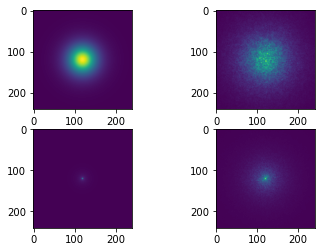

In [13]:
fig = plt.subplot(221);
fig.imshow(tFlux);
fig2 = plt.subplot(222);
fig2.imshow(tFlux_err);
fig3 = plt.subplot(223);
fig3.imshow(fFlux);
fig4 = plt.subplot(224);
fig4.imshow(fFlux_err);

120


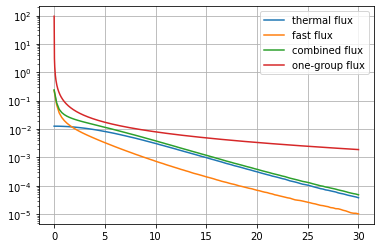

In [14]:
# consider the thermal flux tally with the 1-group flux result

nBins = int((mesh.dimension[0] - 1)/2);
print(nBins)
tFlux_slice = totalflux.mean[0,nBins:,nBins]
fFlux_slice = totalflux.mean[1,nBins:,nBins]
npoints = nBins+1;

r = np.linspace(0,30,num=npoints);

fig = plt.subplot(111);
fig.semilogy(r,tFlux_slice,label='thermal flux');
fig.semilogy(r,fFlux_slice,label='fast flux');
fig.semilogy(r,fFlux_slice+tFlux_slice,label='combined flux');
fig.semilogy(R,one_group_flux,label='one-group flux');
fig.grid(True);
fig.legend();

In [15]:
totalflux.mean[1,nBins:,nBins].max()

0.22807989200048467